<h1>Applied Data Science Capstone Project</h1>
<h3>Battle of the Neighborhoods: Health and Location</h3>
<em>By HAMMAD YOUSUF</em>

## Table of Contents
- [Introduction / Business Problem](#introduction)
- [Data](#data)
- [Methodology](#methodology)
- [Results](#results)
- [Discussion](#discussion)
- [Conclusion](#conclusion)

<a id='introduction'></a>
## Introduction / Business Problem

First off, I thought it would be neat to combine the report and notebook together into one document, and why not?  Isn't that one of the points of Data Science, to provide more timely, interesting, and interactive means of looking at the data?  Isn't that more appetizing?

Now, on to the main course.  Wouldn't it be interesting to show the correlation between certain types of places and certain health indicators?  Proving causation one way or another is well beyond the scope of this project (it's more of a thesis or serious reject paper), but just showing that certain establishments are linked to certain health problems (such as clustering of bars with problems of alchoholism and binge drinking, and obesity with fast food restaurants) could be interesting to both public health officials trying to alleviate the problems with the iron hand of government or unscrupulous business people trying to profit from the misery of others.

And that, in a nutshell (sorry, I guess this is a main course for squirrels, only), is what this project will try to show.

<a id='data'></a>
## Data

To do this kind of project, you need two data sources:  The first is health indicators.  Luckily, the CDC was kind enough to publish a large local data health indicators dataset which I will be using for this project.  <a href="https://chronicdata.cdc.gov/500-Cities/500-Cities-Local-Data-for-Better-Health-2017-relea/6vp6-wxuq">You can find it through here, if you want.</a>

First, let's get and look at the data.  I've already downloaded it, so just need to load it:

In [1]:
import pandas as pd
import numpy as np

# hdf = health data frame
hdf = pd.read_csv("500_Cities__Local_Data_for_Better_Health__2017_release.csv")

In [2]:
print("This data set has {:,} observations of data before cleaning and filtering".format(hdf.size))
print(set(hdf.columns))
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
hdf.head(1)


This data set has 19,442,472 observations of data before cleaning and filtering
{'TractFIPS', 'MeasureId', 'PopulationCount', 'CityFIPS', 'Data_Value', 'GeoLocation', 'Category', 'Low_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'Year', 'StateDesc', 'GeographicLevel', 'CategoryID', 'DataSource', 'High_Confidence_Limit', 'Short_Question_Text', 'CityName', 'Data_Value_Footnote', 'Data_Value_Unit', 'DataValueTypeID', 'Data_Value_Type', 'StateAbbr', 'UniqueID', 'Measure'}


,Year,StateAbbr,StateDesc,CityName,GeographicLevel,DataSource,Category,UniqueID,Measure,Data_Value_Unit,DataValueTypeID,Data_Value_Type,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,Data_Value_Footnote_Symbol,Data_Value_Footnote,PopulationCount,GeoLocation,CategoryID,MeasureId,CityFIPS,TractFIPS,Short_Question_Text
0,2015,US,United States,NaN,US,BRFSS,Prevention,59,Current lack of health insurance among adults aged 18–64 Years,%,AgeAdjPrv,Age-adjusted prevalence,15.4,15.1,15.7,NaN,NaN,308745538.0,NaN,PREVENT,ACCESS2,NaN,NaN,Health Insurance


Let's get rid of some superfulous columns first and filter out some NaNs:

In [3]:
hdf = hdf[['Year','StateAbbr', 'CityName', 'GeographicLevel','DataSource','Category', 'Measure','Data_Value_Unit','Data_Value_Type', 'Data_Value', 'Low_Confidence_Limit','High_Confidence_Limit','PopulationCount','GeoLocation']]
hdf = hdf[hdf.StateAbbr.notnull()]
hdf = hdf[hdf.GeoLocation.notnull()]
hdf = hdf[hdf.StateAbbr != 'US']
hdf = hdf[hdf.PopulationCount > 100] # Filtering out tiny or rare problems
hdf.size


10981544

In [4]:
cityMeanPop = hdf[hdf.GeographicLevel == 'City'].PopulationCount.mean()
censusTractMeanPop = hdf[hdf.GeographicLevel == 'Census Tract'].PopulationCount.mean()
print("City population mean is: {}, and census tract population mean is: {}".format(cityMeanPop,censusTractMeanPop ))

City population mean is: 206041.616, and census tract population mean is: 3811.3100756746467


In [5]:
set(hdf[(hdf.GeographicLevel == 'City') & (hdf.PopulationCount > 4000000)].CityName)

{'New York'}

In [6]:
hdf[(hdf.CityName == 'New York') & (hdf.GeographicLevel != 'City')].size

827414

To simplify the analysis, we are going to drop all cities except New York, and also drop city wide data:

In [7]:
hdf = hdf[(hdf.CityName == 'New York') & (hdf.GeographicLevel != 'City')]

In [8]:
print("How many types of data values are there?  Just % based: {}".format(set(hdf['Data_Value_Unit'])))

How many types of data values are there?  Just % based: {'%'}


In [9]:
indicators = set(hdf.Measure)
pd.options.display.float_format = '{:,.0f}'.format
print("There are: {} health indicators.  Let's choose the easiest.  Here are all of them as a dataset:".format(len(indicators)))
hdf['affected'] = round(hdf['Data_Value']*hdf['PopulationCount']/100)
health_problems = hdf[['Measure','affected']].groupby('Measure').sum()
health_problems.sort_values(by='affected', ascending=False,inplace=True)
health_problems

There are: 28 health indicators.  Let's choose the easiest.  Here are all of them as a dataset:


,affected
Measure,
Papanicolaou smear use among adult women aged 21–65 Years,"6,523,272"
Cholesterol screening among adults aged >=18 Years,"6,131,492"
Mammography use among women aged 50–74 Years,"6,068,531"
Taking medicine for high blood pressure control among adults aged >=18 Years with high blood pressure,"5,961,371"
Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,"5,884,990"
Visits to dentist or dental clinic among adults aged >=18 Years,"4,938,664"
"Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 Years","4,915,002"
Sleeping less than 7 hours among adults aged >=18 Years,"3,373,203"
High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,"2,826,012"


So it looks like the biggest problems are:
* Sleeping less than 7 hours
* High cholestoral / blood pressure / obesity
* No leisure time activity
* Arthritis
* Smoking
* Binge drinking

Among these, I would say that obesity is the easiest to measure versus different types of venues (restaurants, especially fast food restaurants).  Binge drinking, no leisure time, and lack of sleep (especially for the city that never sleeps) could also make interesting areas of study, but we are going to stick to the easiest for this project.

So, let's take out everything else:

In [10]:
hdf = hdf[hdf.Measure.isin(['Obesity among adults aged >=18 Years'])]
hdf.size

31665

Next, let's filter more columns out!  Luckily, the year is the same for all observations, so we don't have to worry about trends or anything like that.

In [64]:
print("Years: {}".format(set(hdf.Year)))
# change name to odf, 'obesity' to keep hdf just in case
odf = hdf[['Data_Value', 'PopulationCount', 'affected']]
odf.columns = ["Percent", "Population", "Affected"]
odf.loc[:,'County'] = np.NaN
odf.loc[:,'BlockCode'] = np.NaN
odf.loc[:,'Pop'] = np.NaN
odf.loc[:,'Lat'] = np.NaN
odf.loc[:,'Long'] = np.NaN

odf.head()

Years: {2015}


c:\users\jeremy\miniconda\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\jeremy\miniconda\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Percent,Population,Affected,County,BlockCode,Pop,Lat,Long
498769,37.80000,"5,810.00000","2,196.00000",nan,nan,nan,nan,nan
498790,37.00000,"2,031.00000",751.00000,nan,nan,nan,nan,nan
499084,38.30000,"4,669.00000","1,788.00000",nan,nan,nan,nan,nan
499105,34.10000,"5,853.00000","1,996.00000",nan,nan,nan,nan,nan
499252,35.20000,"2,711.00000",954.00000,nan,nan,nan,nan,nan


In [65]:
import tqdm
i = 0
for ls in tqdm.tqdm(hdf.GeoLocation):
    lat, long = [float(l) for l in ls[1:-1].split(", ")]
    odf.iloc[i,6] = lat
    odf.iloc[i,7] = long
    i += 1
    

  0%|                                                                                                                                        | 0/2111 [00:00<?, ?it/s]c:\users\jeremy\miniconda\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\jeremy\miniconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\jeremy\miniconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

In [75]:
odf = odf.reset_index(drop=True)
pd.options.display.float_format = '{:,.5f}'.format
odf.loc[:,'sw'] = np.NaN
odf.loc[:,'ne'] = np.NaN
odf.head()

,Percent,Population,Affected,County,BlockCode,Pop,Lat,Long,sw,ne
0,37.80000,"5,810.00000","2,196.00000",Bronx,360050051002009,12.00000,40.81331,-73.92738,nan,nan
1,37.00000,"2,031.00000",751.00000,NaN,NaN,nan,40.82564,-73.88244,nan,nan
2,38.30000,"4,669.00000","1,788.00000",NaN,NaN,nan,40.85221,-73.92178,nan,nan
3,34.10000,"5,853.00000","1,996.00000",NaN,NaN,nan,40.82989,-73.87978,nan,nan
4,35.20000,"2,711.00000",954.00000,NaN,NaN,nan,40.83261,-73.87908,nan,nan


In [57]:
res

('Bronx', '360050051002009', [-73.928542, 40.811725, -73.926715, 40.813589])

Now, we are going to use the FCC's geocoding api to assign counties as well as block fips ids.  If there are any overlapping block fips we will merge them like with the Toronto homework.

In [82]:
import requests
def getLocation(lat,long):
    try:
        res = requests.get("https://geo.fcc.gov/api/census/area?lat={}&lon={}&format=json".format(lat,long))
        res = res.json()['results'][0]
        block = res['block_fips']
        county = res['county_name']
        bbox = res['bbox']
        pop = res['block_pop_2015']
        sw = ",".join([str(e) for e in bbox[:2]])
        ne = ",".join([str(e) for e in bbox[2:]])
        return county, block, bbox, pop, sw, ne
    except:
        return


bboxes = []
errors = 0
for i in tqdm.tqdm(range(odf.shape[0])):
    lat = odf.iloc[i,6]
    long = odf.iloc[i,7]
    res = getLocation(lat, long)
    if res:
        odf.iloc[i,3] = res[0]
        odf.iloc[i,4] = res[1]
        odf.iloc[i,5] = res[3]
        odf.iloc[i,8] = res[4]
        odf.iloc[i,9] = res[5]
        bboxes.append(res[2])
    else:
        errors += 1
        
odf.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2111/2111 [03:05<00:00, 11.38it/s]


,Percent,Population,Affected,County,BlockCode,Pop,Lat,Long,sw,ne
0,37.80000,"5,810.00000","2,196.00000",Bronx,360050051002009,12.00000,40.81331,-73.92738,"-73.928542,40.811725","-73.926715,40.813589"
1,37.00000,"2,031.00000",751.00000,Bronx,360050052001001,5.00000,40.82564,-73.88244,"-73.883552,40.825398","-73.882275,40.828304"
2,38.30000,"4,669.00000","1,788.00000",Bronx,360050053001000,"2,023.00000",40.85221,-73.92178,"-73.923904,40.850341","-73.921334,40.85254"
3,34.10000,"5,853.00000","1,996.00000",Bronx,360050054002001,985.00000,40.82989,-73.87978,"-73.880699,40.828511","-73.879171,40.831139"
4,35.20000,"2,711.00000",954.00000,Bronx,360050056001001,18.00000,40.83261,-73.87908,"-73.879368,40.831265","-73.876993,40.83376"


In [83]:
print("How many duplicate block codes are there? Let's see: {}/{}".format(odf.size-odf.groupby('BlockCode').agg("count").size,odf.size))

How many duplicate block codes are there? Let's see: 2111/21110


Since there seems to be little correlation between population from the cdc data and "block" level population, I believe it is a mistake to use this data.  Let's go ahead and drop it.  This was an unfortunate path to waste time on.  At least we can keep the county codes.

In [85]:
df = odf.drop(columns=['BlockCode','Pop','sw','ne'])
df.head()

,Percent,Population,Affected,County,Lat,Long
0,37.80000,"5,810.00000","2,196.00000",Bronx,40.81331,-73.92738
1,37.00000,"2,031.00000",751.00000,Bronx,40.82564,-73.88244
2,38.30000,"4,669.00000","1,788.00000",Bronx,40.85221,-73.92178
3,34.10000,"5,853.00000","1,996.00000",Bronx,40.82989,-73.87978
4,35.20000,"2,711.00000",954.00000,Bronx,40.83261,-73.87908


Instead of using that data, we will use a radial search around the areas of interest.  Now, finally, we can move on to the restaurant data.  Let's save this data first, so we can come back to it without all of that work in the future.

In [86]:
df.to_csv('fat_neighborhoods')

In [61]:
import pandas as pd
import numpy as np
import requests, tqdm, os
fs_id, fs_secret = os.environ['FOURSQUARE_ID'], os.environ['FOURSQUARE_SECRET']

df = pd.read_csv('fat_neighborhoods',index_col=0)
df['Restaurants'] = 0
df.head()

,Percent,Population,Affected,County,Lat,Long,Restaurants
0,37.8,5810.0,2196.0,Bronx,40.813308,-73.927382,0
1,37.0,2031.0,751.0,Bronx,40.825642,-73.882436,0
2,38.3,4669.0,1788.0,Bronx,40.852212,-73.921778,0
3,34.1,5853.0,1996.0,Bronx,40.829888,-73.879781,0
4,35.2,2711.0,954.0,Bronx,40.832612,-73.879076,0


In [98]:
df.Percent.describe()

count    1615.000000
mean       24.857276
std         6.488555
min        10.900000
25%        19.300000
50%        24.600000
75%        30.100000
max        43.900000
Name: Percent, dtype: float64

Above, we can see that there is a tremendous amount of variation in obesities across different locations.  That is pretty amazing, no matter the causes or relationships involved!  Let's see how they look like in terms of actual locations:

<module 'folium.features' from 'c:\\users\\jeremy\\miniconda\\lib\\site-packages\\folium\\features.py'>


In [121]:
import folium

min_fat = df.Percent.min()
max_fat = df.Percent.max()
fat_range = max_fat-min_fat
color_scaler = (fat_range)/255
def percToRed(perc):
    return '#%02x%02x%02x' % (255, 255-int(perc*255), 255-int(perc*255))

avg_lat = df.Lat.mean()
avg_long = df.Long.mean()
fat_map = folium.Map(location=[avg_lat,avg_long], zoom_start=11) # generate map centred around Ecco

for lat, lng, perc in zip(df.Lat, df.Long, df.Percent):
    color = percToRed((perc-min_fat)/fat_range)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=folium.Popup(str(int(perc)), parse_html=True),
        fill=True,
        color=color,
        fill_color=color,
        fill_opacity=0.6
        ).add_to(fat_map)

In [122]:
# display map
fat_map

Here is the map in case you cannot see the interactive one above:
![Obesity Map](fat_map.jpg)
As I discuss below, it is most likely that obesity and income are very closely linked.  However, there seems to be more than just that going on above (although I don't know enough about New York incomes by neighborhood or real estate prices to discuss this intelligently, and that is beyond the scope of the current project)


In [2]:
LIMIT = 50
FOOD = "4d4b7105d754a06374d81259"
VERSION = '20201231'


def getNearbyRestaurants(lat,lng, radius=500):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        FOOD,
        fs_id, 
        fs_secret, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)  
    # make the GET request
    try:
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        return [v['venue']['categories'][0]['name'] for v in results]
    except:
        return []

restaurant_types = []
for i in tqdm.tqdm(range(df.shape[0])):
    row = df.iloc[i]
    Percent, Population, Affected, County, Lat, Long, nRests = row
    restaurants = getNearbyRestaurants(Lat,Long)
    df.iloc[i,6] = len(restaurants)
    restaurant_types.append(restaurants)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2111/2111 [11:03<00:00,  3.18it/s]


In [62]:
rest_types = set([r for rs in restaurant_types for r in rs])
rest_type_counts = {t: 0 for t in rest_types}
i = 0
for rs in tqdm.tqdm(restaurant_types):
    df.iloc[i,6] = len(rs)
    for r in rs:
        rest_type_counts[r] += 1
    i += 1
print("Here are the types and counts of food there are:")
rest_type_counts

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2111/2111 [00:00<00:00, 2220.69it/s]


Here are the types and counts of food there are:


{'Tapas Restaurant': 141,
 'Tibetan Restaurant': 25,
 'Hunan Restaurant': 3,
 'Souvlaki Shop': 12,
 'Mexican Restaurant': 2091,
 'Kosher Restaurant': 43,
 'French Restaurant': 458,
 'Venezuelan Restaurant': 18,
 'Burmese Restaurant': 6,
 'Wings Joint': 139,
 'Doner Restaurant': 2,
 'Falafel Restaurant': 143,
 'Comfort Food Restaurant': 42,
 'BBQ Joint': 287,
 'Colombian Restaurant': 25,
 'Latin American Restaurant': 973,
 'Creperie': 58,
 'Moroccan Restaurant': 26,
 'Sandwich Place': 1647,
 'Southern / Soul Food Restaurant': 300,
 'Peruvian Restaurant': 155,
 'Mac & Cheese Joint': 14,
 'Pakistani Restaurant': 20,
 'Indian Restaurant': 745,
 'Theme Restaurant': 7,
 'Hong Kong Restaurant': 5,
 'Ethiopian Restaurant': 43,
 'Cajun / Creole Restaurant': 54,
 'Shanghai Restaurant': 42,
 'Persian Restaurant': 12,
 'African Restaurant': 116,
 'Molecular Gastronomy Restaurant': 3,
 'New American Restaurant': 359,
 'Dumpling Restaurant': 91,
 'Food Truck': 1098,
 'Breakfast Spot': 348,
 'Burrito

In [63]:
used_restaurants = set([r for r,c in rest_type_counts.items() if c > 100])
print ("We are going to use {}/{} restaurants with the cutoff being there are at least 100 of this type of restaurant in our entire dataset.  This will simplify things but still keep a lot of variety".format(len(used_restaurants),len(rest_type_counts)))

We are going to use 55/141 restaurants with the cutoff being there are at least 100 of this type of restaurant in our entire dataset.  This will simplify things but still keep a lot of variety


In [64]:
for rest in used_restaurants:
    df.loc[:,rest] = 0
    
i = 0
for rs in tqdm.tqdm(restaurant_types):
    for r in [r for r in rs if r in used_restaurants]:
        df.loc[i,r] += 1
    i += 1
df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2111/2111 [00:19<00:00, 109.14it/s]


,Percent,Population,Affected,County,Lat,Long,Restaurants,Tapas Restaurant,Steakhouse,Korean Restaurant,...,African Restaurant,Fast Food Restaurant,Chinese Restaurant,South American Restaurant,Café,Eastern European Restaurant,New American Restaurant,Food Truck,Breakfast Spot,Diner
0,37.8,5810.0,2196.0,Bronx,40.813308,-73.927382,19,0,0,0,...,0,0,2,1,0,0,0,2,1,0
1,37.0,2031.0,751.0,Bronx,40.825642,-73.882436,13,0,1,0,...,0,0,2,0,0,0,0,0,0,0
2,38.3,4669.0,1788.0,Bronx,40.852212,-73.921778,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34.1,5853.0,1996.0,Bronx,40.829888,-73.879781,32,0,1,0,...,0,2,3,0,0,0,0,0,0,2
4,35.2,2711.0,954.0,Bronx,40.832612,-73.879076,26,0,1,0,...,0,2,3,0,0,0,0,0,0,2


Let's also drop any areas that have less than double digit restaurants, and normalize the data for restaurants to be percentages instead of absolute values:

In [79]:
df = df[df.Restaurants > 9]
df = df.reset_index(drop=True)
for rest in used_restaurants:
    df[rest] = df[rest]/df.Restaurants

And we finally have a pretty useful dataset!  WHEW!  So much work for such a simple thing.  Let's save it so we can start again from here.

In [81]:
df.to_csv('real_data')

In [97]:
import pandas as pd
import numpy as np
import requests, tqdm, os
fs_id, fs_secret = os.environ['FOURSQUARE_ID'], os.environ['FOURSQUARE_SECRET']

df = pd.read_csv('real_data',index_col=0)
df.head()
y = df['Percent']
X = df.iloc[:,7:]

The first major data question is: is there a correlation between obesity prevalance and types / number of restaurants in a given area?  If not, that could be for any number of reasons, and if so, the causality might be restaurants or unhealthy restaurants opening nearby to fat people, or it might be people becoming fat because of these restaurants being nearby, or it might even be a spurious correlation.

Well, let's look at a covariance matrix to see:

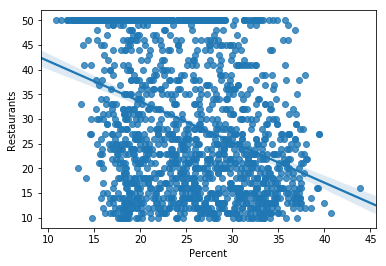

In [74]:
import seaborn as sns
%matplotlib inline

sns.regplot(df['Percent'],df['Restaurants'])

Well, that's interesting.  The less restaurants there are, the fatter people are.  That makes perfect sense, though, as poorer people usually live nearby to less restaurants, and it's well known that wealthy people are less obese on average.

Let's do a simple regression to see if any different types of restaurants are more correlated with obesity.

In [96]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                Percent   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     57.51
Date:                Mon, 24 Sep 2018   Prob (F-statistic):               0.00
Time:                        17:12:04   Log-Likelihood:                -4416.3
No. Observations:                1615   AIC:                             8945.
Df Residuals:                    1559   BIC:                             9246.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Well!  That's pretty interesting!  I didn't expect the p-values to be so low for so many types of food, just as I didn't expect the actual range of obesity percentages by location to be so high!  Again, it may well turn out that most of these can be explained away by differences of income, but perhaps not.  I'm not going to take it upon myself at the moment to explore such relationships in incredible depth (as I am trying to finish this course ASAP!), but it looks like there is a lot going on with the data.

That concludes the initial data section!

<a id='methodology'></a>
## Methodology

The methodology I will use is pretty straightforward.  I will try out a number of different machine learning / statistical learning methods after splitting the data into training and test sets, and find out which ones are best at describing the relationship between food types and obesity.  This is a very simple question, that could be done in a much better way, but I am trying to finish this in one day!  

Let's see how ridge regression does with cross_validation AND various values of the tuning parameter alpha:

In [164]:
from sklearn import linear_model,cross_validation
reg = linear_model.RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], store_cv_values=True)
reg.fit(X, y)       

metrics.mean_squared_error(y_true=y_test, y_pred=reg.predict(X_test))

14.452431906593688

So an alpha of 0.1 is best for this model and ridge regression. Let's compare its performance with OLS (a fuller model using the entire dataset can be seen above, but let's see if r-squared drops a lot when using a test-set instead of just in-sample error:

In [163]:
OLS = linear_model.LinearRegression()

loo = cross_validation.LeaveOneOut(len(y))
scores = cross_validation.cross_val_score(OLS, X, y, scoring='neg_mean_squared_error', cv=loo,)

# This will print the mean of the list of errors that were output and 
# provide your metric for evaluation
print (scores.mean()*-1)

14.937495127


<a id='results'></a>
## Results

So we find that Ridge Regression does slightly better than linear regression, and for now, we will leave it at that!


<a id='conclusion'></a>
## Conclusion

Without a lot more work in the initial data exploration and methodology phase, it would not be possible to figure out what exactly is driving the correlation between obesity and various types of food!

<a id='discussion'></a>
## Discussion

We can see that this topic, the relationship between different types of restaurants in a given area and obesity levels, seems to be rich in interesting correlations!

Finding out if those correlations are mostly driven by income, partially driven by culture, or largely driven by the actual kind of food, would make for quite an interesting master's thesis!  Even this short project has revealed some fascinating correlations in New York City.

In fact, it is quite likely I will return to this data in the future to explore this topic much further!

Thanks for reading.